Encapsulate your work in a wrangle_mall.py python module.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from env import host, user, password

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import os
from pathlib import Path

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format


## Acquire data from the customers table in the mall_customers database.

In [2]:
#URL function
def get_db_url(host, user, password, database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
#Declare the database and url
database = 'mall_customers'

url = get_db_url(host, user, password, database)

In [4]:
#Create the SQL query
query = '''
    SELECT * FROM customers;
    '''

In [5]:
#Read in the dataframe
df = pd.read_sql(query, url)

df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Summarize the data (include distributions and descriptive statistics).

In [6]:
#Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.00,100.50,57.88,1.00,50.75,100.50,150.25,200.00
age,200.00,38.85,13.97,18.00,28.75,36.00,49.00,70.00
annual_income,200.00,60.56,26.26,15.00,41.50,61.50,78.00,137.00
spending_score,200.00,50.20,25.82,1.00,34.75,50.00,73.00,99.00


In [7]:
#Shape of the dataframe
df.shape

(200, 5)

(0.0, 100.0)

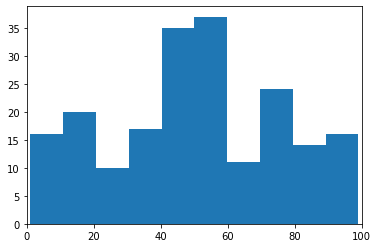

In [8]:
#Distribution of target variable
plt.hist(x=df['spending_score'])
plt.xlim(0, 100)

## Detect outliers using IQR.

In [9]:
#Define function to drop columns/rows based on proportion of nulls
def null_dropper(df, prop_required_column, prop_required_row):
    
    prop_null_column = 1 - prop_required_column
    
    for col in list(df.columns):
        
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns=col, inplace=True)
            
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis=0, thresh=row_threshold, inplace=True)
    
    return df

In [10]:
#Execute my function and visualize the results
clean_df = null_dropper(df, 0.75, 0.75)

clean_df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
#Check shape of resulting dataframe
clean_df.shape

(200, 5)

## Encode categorical columns using a one hot encoder (pd.get_dummies) and Handles missing values.

In [12]:
df=clean_df

In [13]:
def prep_mall_customer_data(df):
    #Replace a whitespace sequence or empty with a NaN value and reassign this manipulation to df.
    df = df.replace(r'^\s*$', np.nan, regex=True)
    
    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({"Male":0,"Female":1})
    
    df.drop(columns=['gender'], inplace=True)
    
    return df

In [14]:
prep_mall_customer_data(df)

,customer_id,age,annual_income,spending_score,gender_encoded
0,1,19,15,39,0
1,2,21,15,81,0
2,3,20,16,6,1
3,4,23,16,77,1
4,5,31,17,40,1
...,...,...,...,...,...
195,196,35,120,79,1
196,197,45,126,28,1
197,198,32,126,74,0
198,199,32,137,18,0


In [15]:
df=prep_mall_customer_data(df)

## Split data into train, validate, and test.

In [16]:
def split_mall_customer_data(df):
    '''
    This function performs split on our data.  Purpose of the train, validate, test is to split a dataframe.  
    The train dataset is for training our models. We also perform our exploratory data analysis on train.  
    The validate dataset serves two purposes. First, it is an "out of sample" dataset so that we can evaluate our models 
    on unseen data to measure how well the model generalizes. Second, the validate set allows us to fine tune 
    our hyperparameters.  The test dataset is our final out of sample dataset used to evaluate how well the models 
    tuned on validate generalize on unseen data. Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)
    return train, validate, test

In [17]:
split_mall_customer_data(df)

(     customer_id  age  annual_income  spending_score  gender_encoded
 123          124   39             69              91               0
 76            77   45             54              53               1
 171          172   28             87              75               0
 10            11   67             19              14               0
 35            36   21             33              81               1
 ..           ...  ...            ...             ...             ...
 175          176   30             88              86               1
 101          102   49             62              48               1
 148          149   34             78              22               1
 99           100   20             61              49               0
 22            23   46             25               5               1
 
 [112 rows x 5 columns],
      customer_id  age  annual_income  spending_score  gender_encoded
 68            69   19             48              59          

In [18]:
train, validate, test=split_mall_customer_data(df)

In [19]:
train.head()

,customer_id,age,annual_income,spending_score,gender_encoded
123,124,39,69,91,0
76,77,45,54,53,1
171,172,28,87,75,0
10,11,67,19,14,0
35,36,21,33,81,1


In [20]:
train.shape

(112, 5)



## Scaling

In [21]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale = ['gender_encoded', 'age', 'spending_score'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = MinMaxScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                           columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [22]:
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, 
               validate, 
               test, 
               columns_to_scale = ['gender_encoded', 'age', 'spending_score'],
               return_scaler=False)

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# allows you to see before and after scaling of data
def visualize_scaler(scaler, df, columns_to_scale, bins=5):
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(16,9))
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#return fig, axs